<a href="https://colab.research.google.com/github/ErickAlcaino/Proyectos/blob/main/Sentimiento%20de%20Frases%20ML/SentimientoFrasesML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Contexto.

Análisis de sentimiento es el proceso de analizar texto digital para determinar si el tono emocional del mensaje es positivo o negativo. Hoy en día, las empresas cuentan con grandes volúmenes de datos en texto, como correos electrónicos, transcripciones de chats de atención al cliente, comentarios en redes sociales y reseñas. Las herramientas de análisis de sentimiento pueden escanear estos textos para determinar automáticamente la actitud del autor hacia un tema. Las empresas usan las ideas obtenidas del análisis de sentimiento para mejorar el servicio al cliente y aumentar la reputación de la marca.

# Dataset

En dataset utilizado corresponde a frases en ingles de peliculas. Son 3000 frases, con valor 1 cuando corresponde a un sentimiento positivo y valor 0 cuando es negativo.


#Enfoque

Se busca el mejor modelo de Machine Learning.




**El documento está en ingles ya que subí este colab a Kaggle, que es una pagina donde se practican habilidades de ML y redes. Link: https://www.kaggle.com/code/erickalexisalcano/best-ml-model-with-bow-tf-and-vect2word-methods**

# Best ML for BOW, TFIDF and V2W methods.

This is my first notebook in Kaggle. Im going to use 3 methods to vectorize the phrases. BOW, TFIDF and WOrd2Vect. Then we test a lot of models and we select the best. Then we plot wordCloud and Roc curve to see performance. Finally, we move the umbral of decision of the model just for fun :)


In [1]:
# Manejo de datos
import numpy as np
import pandas as pd
import gensim
import re

import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from string import punctuation

# Visualizacion
import matplotlib.pyplot as plt
import seaborn as sns

#CLoud de plaabras
from wordcloud import WordCloud

# sklearn


from sklearn.feature_selection import mutual_info_classif
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay,classification_report,accuracy_score
from sklearn.metrics import f1_score, roc_auc_score, roc_curve, auc
from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import cross_val_score, StratifiedKFold, train_test_split,RepeatedKFold,KFold
from sklearn.tree import plot_tree, DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier


from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB, GaussianNB

from gensim.models import Word2Vec,  KeyedVectors
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


## Useful functions


In [2]:
def plot_cm(y_pred, y_test, LABELS,titulo ,grados = 0):
  "Función para graficar matriz de confusión"
  ConfusionMatrixDisplay.from_predictions(
        y_test,
        y_pred,
        cmap=plt.cm.Blues,
      display_labels = LABELS
  )
  plt.xticks(rotation=grados)
  plt.title('Confusion Matrix'+str(titulo))
  plt.show()

def datainfo(data):
    temp_ps = pd.DataFrame(index=data.columns)
    temp_ps['DataType'] = data.dtypes
    temp_ps["Non-null_Values"] = data.count()
    temp_ps['Unique_Values'] = data.nunique()
    temp_ps['NaN_Values'] = data.isnull().sum()
    temp_ps['NaN_Values_Percentage'] = (temp_ps['NaN_Values']/len(data))*100
    return temp_ps


def Validacion_Cruzada(modelos, X_vec, y, paquetes=5):
  for nombre, modelo in modelos.items():
    scores = cross_val_score(modelo, X_vec, y, cv=paquetes, scoring='accuracy')
    mean_accuracy = np.mean(scores)
    std_accuracy = np.std(scores)

    print(f"Precisión promedio con {nombre}: {mean_accuracy:.4f} ± {std_accuracy:.4f}")

def clean_text(text):
    # Eliminar todo lo que no sea letras, espacios o comas
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Eliminar múltiples espacios
    text = re.sub(r'\s+', ' ', text).strip()
    return text

def procesamientoWord2Vec(texto):
    mystopwords = set(stopwords.words("english"))
    def remove_stops_digits(tokens):
        #palabras válidas que no son stopwords, no son dígitos y no son signos de puntuación.
        return [token.lower() for token in tokens if token.lower() not in mystopwords and not token.isdigit()
               and token not in punctuation]
    return [remove_stops_digits(word_tokenize(text)) for text in texto]


def embedding_feats(list_of_lists):
    DIMENSION = 300
    zero_vector = np.zeros(DIMENSION)
    feats = []
    for tokens in list_of_lists:
        feat_for_this =  np.zeros(DIMENSION)
        count_for_this = 0 + 1e-5 # to avoid divide-by-zero
        for token in tokens:
            if token in w2v_model:
                feat_for_this += w2v_model[token]
                count_for_this +=1
        if(count_for_this!=0):
            feats.append(feat_for_this/count_for_this)
        else:
            feats.append(zero_vector)
    return feats

We use the pretrainned model of google.

In [3]:
pretrain_w2v = '/content/drive/My Drive/Data/sentiment labelled sentences/GoogleNews-vectors-negative300.bin'
w2v_model = KeyedVectors.load_word2vec_format(pretrain_w2v, binary=True)

## DataFrame and Cleaning
with "pd.read_csv('/content/drive/My Drive/Data/sentiment labelled sentences/imdb_labelled.txt', delimiter='\t', header=None)", u get 748/1000 raws, so i need to use another code.

In [4]:
# IMDB estaba solo sacando 748 filas en vez de las 1000, por eso este codigo.
data = []
with open('/content/drive/My Drive/Data/sentiment labelled sentences/imdb_labelled.txt', 'r', encoding='utf-8') as file:
  for line in file:
    line = line.strip()  # Remove leading/trailing whitespace
    if line:  # Skip empty lines
      try:
        parts = line.split('\t')  # Split by tab delimiter
        if len(parts) == 2:
          data.append(parts)
        else:
          print(f"Skipping invalid line: {line}")  # Identify problematic lines
      except Exception as e:
        print(f"Error parsing line: {line}, Error: {e}")  # Handle parsing errors

imdb = pd.DataFrame(data)

print(f"Rows loaded: {len(imdb)}")

Rows loaded: 1000


Create pd.dataFrame and Str.lower and replace dots with space for case like "hello...how are u?".

In [5]:
amazon=pd.read_csv('/content/drive/My Drive/Data/sentiment labelled sentences/amazon_cells_labelled.txt', delimiter='\t', header=None)
#imdb=pd.read_csv('/content/drive/My Drive/Data/sentiment labelled sentences/imdb_labelled.txt', delimiter='\t', header=None) #Este no funciona bien
yelp=pd.read_csv('/content/drive/My Drive/Data/sentiment labelled sentences/yelp_labelled.txt', delimiter='\t', header=None)
texto=pd.concat([amazon,imdb,yelp])
texto.columns=['Frases','Valor']
texto['Valor'] = pd.to_numeric(texto['Valor']).astype(int)

display(datainfo(texto))

#Todas las frases en  minusculaaaa
texto['Frases'] = texto['Frases'].str.lower()
texto['Frases'] = texto['Frases'].str.replace(r'\.', ' ', regex=True)


display(texto[texto['Valor']==1])


,DataType,Non-null_Values,Unique_Values,NaN_Values,NaN_Values_Percentage
Frases,object,3000,2983,0,0.0
Valor,int64,3000,2,0,0.0


,Frases,Valor
1,"good case, excellent value",1
2,great for the jawbone,1
4,the mic is great,1
7,if you are razr owner you must have this!,1
10,and the sound quality is great,1
...,...,...
899,"overall, a great experience",1
901,their regular toasted bread was equally satisf...,1
907,the chips and sals a here is amazing!!!!!!!!!!...,1
909,this is my new fav vegas buffet spot,1


Clean symbols like ?@$*, etc.

In [6]:
texto['Frases'] = texto['Frases'].apply(clean_text)
display(texto[texto['Valor']==1])

,Frases,Valor
1,good case excellent value,1
2,great for the jawbone,1
4,the mic is great,1
7,if you are razr owner you must have this,1
10,and the sound quality is great,1
...,...,...
899,overall a great experience,1
901,their regular toasted bread was equally satisf...,1
907,the chips and sals a here is amazing,1
909,this is my new fav vegas buffet spot,1


Numero de filas con Valor 1: 1500

Numero de filas con Valor 0: 1500



([<matplotlib.axis.XTick at 0x793629958640>,
 [Text(0, 0, '0'), Text(1, 0, '1')])

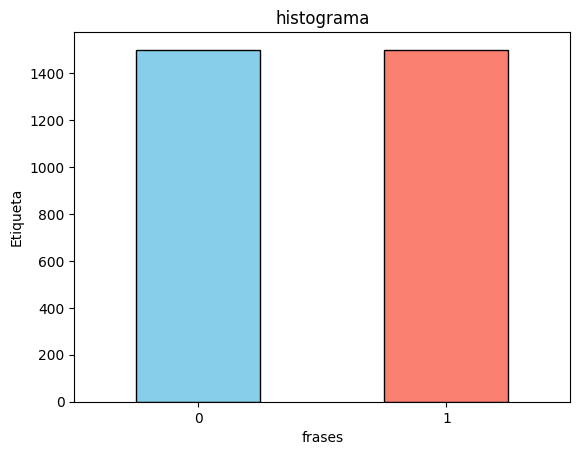

In [7]:

print(f"Numero de filas con Valor 1: {len(texto[texto['Valor'] == 1])}\n")
print(f"Numero de filas con Valor 0: {len(texto[texto['Valor'] == 0])}\n")
valor_counts = texto['Valor'].value_counts()
valor_counts.plot(kind='bar', edgecolor='black',color=['skyblue', 'salmon'])

plt.title('histograma')
plt.xlabel('frases')
plt.ylabel('Etiqueta')
plt.xticks([0, 1], rotation=0)

## Define models to use.

In [8]:
modelos = {
    "Naive Bayes": MultinomialNB(),
    "Decision Tree": DecisionTreeClassifier(),
    "SVM": SVC(),
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(),
    "KNN": KNeighborsClassifier(),
    "Gradient Boosting": GradientBoostingClassifier()
}

modelosW2V = {
    "Decision Tree": DecisionTreeClassifier(),
    "SVM": SVC(),
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(),
    "KNN": KNeighborsClassifier(),
    "Gradient Boosting": GradientBoostingClassifier()
}

mejorModelosBOW= {
    "Naive Bayes": MultinomialNB(),
    "Logistic Regression": LogisticRegression(max_iter=1000),
}

mejorModelosTF= {
    "Naive Bayes": MultinomialNB(),
    "SVM": SVC(),
    "Logistic Regression": LogisticRegression(max_iter=1000),
}

mejorModelosW2V= {
    "SVM": SVC(),
    "Logistic Regression": LogisticRegression(max_iter=1000),
    #"Gradient Boosting": GradientBoostingClassifier() #SE DEMORA MUCHO XD, pero es weno al parecer (NI TAN WENO)
}

X = texto['Frases']
y = texto['Valor']

## Test Every Methods with models searching the best ones.
**Lets test every model with BOW, TFADF and V2W.**

In [9]:
vectorizer = CountVectorizer()
X_BOW = vectorizer.fit_transform(X)

print('BOW Vectorizacion:\n')

Validacion_Cruzada(modelos,X_BOW,y, paquetes=5)

BOW Vectorizacion:

Precisión promedio con Naive Bayes: 0.8090 ± 0.0083
Precisión promedio con Decision Tree: 0.7270 ± 0.0349
Precisión promedio con SVM: 0.7770 ± 0.0431
Precisión promedio con Logistic Regression: 0.8023 ± 0.0227
Precisión promedio con Random Forest: 0.7803 ± 0.0188
Precisión promedio con KNN: 0.6420 ± 0.0270
Precisión promedio con Gradient Boosting: 0.7507 ± 0.0308


In [10]:
tfidf_vectorizer = TfidfVectorizer()
X_TF= tfidf_vectorizer.fit_transform(X)

print('TF Vectorizacion:\n')

Validacion_Cruzada(modelos,X_TF,y, paquetes=5)

TF Vectorizacion:

Precisión promedio con Naive Bayes: 0.8107 ± 0.0116
Precisión promedio con Decision Tree: 0.6983 ± 0.0152
Precisión promedio con SVM: 0.8147 ± 0.0190
Precisión promedio con Logistic Regression: 0.8037 ± 0.0240
Precisión promedio con Random Forest: 0.7643 ± 0.0179
Precisión promedio con KNN: 0.7083 ± 0.0269
Precisión promedio con Gradient Boosting: 0.7450 ± 0.0315


In [11]:
X_process = procesamientoWord2Vec(X)
X_vec = embedding_feats(X_process)

print('Word2vec Vectorizacion:\n')

Validacion_Cruzada(modelosW2V,X_vec,y, paquetes=5)

Word2vec Vectorizacion:

Precisión promedio con Decision Tree: 0.6487 ± 0.0165
Precisión promedio con SVM: 0.8217 ± 0.0179
Precisión promedio con Logistic Regression: 0.8097 ± 0.0209
Precisión promedio con Random Forest: 0.7937 ± 0.0164
Precisión promedio con KNN: 0.7430 ± 0.0229
Precisión promedio con Gradient Boosting: 0.7993 ± 0.0166


## Best Models
We test the best models of each method with more packages

In [12]:
vectorizer = CountVectorizer()
X_BOW = vectorizer.fit_transform(X)

tfidf_vectorizer = TfidfVectorizer()
X_TF= tfidf_vectorizer.fit_transform(X)

X_process = procesamientoWord2Vec(X)
X_vec = embedding_feats(X_process)

print('\nBOW Vectorizacion:\n')
Validacion_Cruzada(mejorModelosBOW, X_BOW,y, paquetes=30)

print('\nTF Vectorizacion:\n')
Validacion_Cruzada(mejorModelosTF,X_TF,y, paquetes=30)


print('\nWord2vec Vectorizacion:\n')
Validacion_Cruzada(mejorModelosW2V,X_vec,y, paquetes=30)


BOW Vectorizacion:

Precisión promedio con Naive Bayes: 0.8217 ± 0.0311
Precisión promedio con Logistic Regression: 0.8253 ± 0.0437

TF Vectorizacion:

Precisión promedio con Naive Bayes: 0.8253 ± 0.0308
Precisión promedio con SVM: 0.8323 ± 0.0442
Precisión promedio con Logistic Regression: 0.8227 ± 0.0422

Word2vec Vectorizacion:

Precisión promedio con SVM: 0.8273 ± 0.0427
Precisión promedio con Logistic Regression: 0.8193 ± 0.0357


WordCloud of more relevant word ignoring stop_words.

## We choose TFIDF with SVM

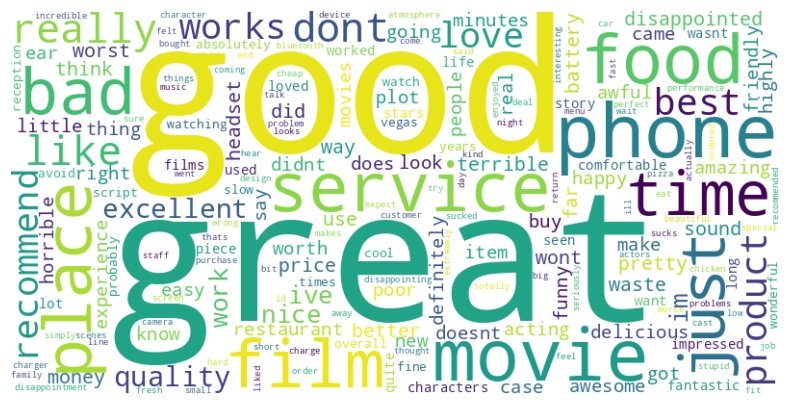

In [13]:
tfidf_vectorizer = TfidfVectorizer(stop_words ='english')
X_TF= tfidf_vectorizer.fit_transform(X)

suma_tfidf = X_TF.sum(axis=0)

# Muestra palabras no conectores, que aparecen mucho y 'son raras' (aparecer mucho pondera casi todo en realidad)
palabras_tfidf = {palabra: suma_tfidf[0, idx] for palabra, idx in tfidf_vectorizer.vocabulary_.items()}

# Genera la nube de palabras
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(palabras_tfidf)

# Muestra la nube de palabras
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()



In [14]:
tfidf_vectorizer = TfidfVectorizer()
X_TF= tfidf_vectorizer.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_TF, y, test_size=0.1, random_state=42)

## Performance of SVM

Classification Report svc:
              precision    recall  f1-score   support

           0       0.80      0.87      0.83       136
           1       0.88      0.82      0.85       164

    accuracy                           0.84       300
   macro avg       0.84      0.84      0.84       300
weighted avg       0.84      0.84      0.84       300

Accuracy SVC: 0.84


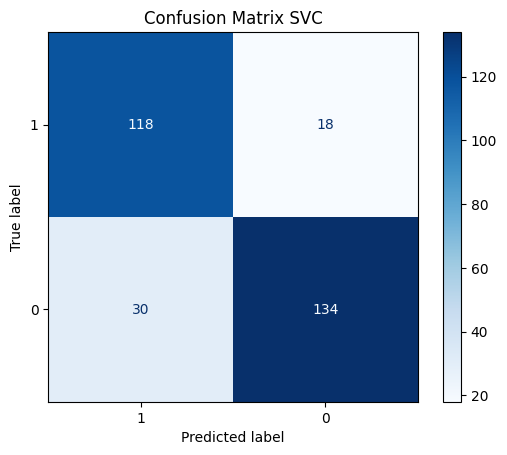

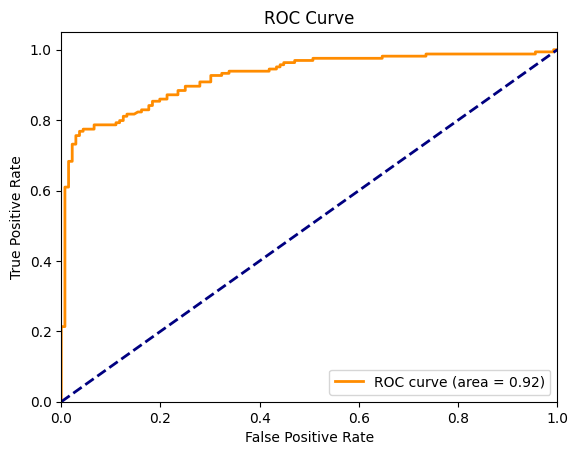

In [15]:
svc= SVC()
svc.fit(X_train, y_train)

y_svc_pred = svc.predict(X_test)

print("Classification Report svc:")
print(classification_report(y_test, y_svc_pred, target_names = ['0', '1']))


# Evaluar el rendimiento del modelo
accuracy = accuracy_score(y_test, y_svc_pred)
print("Accuracy SVC:", accuracy)
plot_cm(y_svc_pred, y_test,['1', '0'],' SVC')


svc = SVC(probability=True)
svc.fit(X_train, y_train)
y_score = svc.predict_proba(X_test)[:, 1]  # Predicción de la probabilidad para la clase positiva
fpr, tpr, thresholds = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)


# Plotear la curva ROC
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

## Change Umbral for fun :)

Classification Report con umbral que maximiza F1-score:
              precision    recall  f1-score   support

           0       0.78      0.96      0.86       136
           1       0.95      0.77      0.86       164

    accuracy                           0.86       300
   macro avg       0.87      0.87      0.86       300
weighted avg       0.87      0.86      0.86       300


Accuracy SVC: 0.8566666666666667 



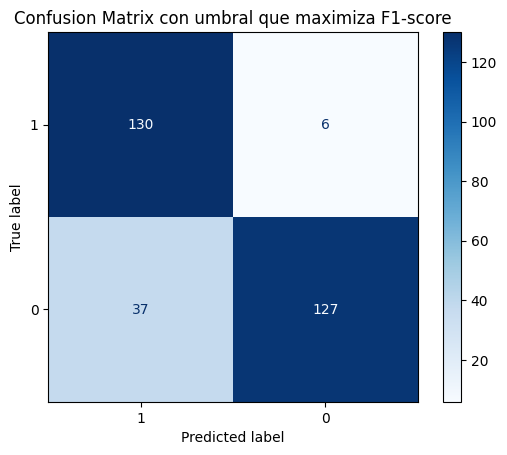

In [16]:

y_proba = svc.predict_proba(X_test)[:, 1]

# Definir los posibles umbrales (podemos probar valores entre 0 y 1)
umbrales = np.arange(0.1, 1.0, 0.01)
f1_scores = []
for umbral in umbrales:
    y_pred_temp = (y_proba >= umbral).astype(int)
    f1 = f1_score(y_test, y_pred_temp)
    f1_scores.append(f1)

# Encontrar el umbral que maximiza el F1-score
idx_max_f1 = np.argmax(f1_scores)
umbral_optimo_f1 = umbrales[idx_max_f1]
y_pred_optimo = (y_proba >= umbral_optimo_f1).astype(int)


print("Classification Report con umbral que maximiza F1-score:")
print(classification_report(y_test, y_pred_optimo, target_names=['0', '1']))

accuracy = accuracy_score(y_test, y_pred_optimo)
print("\nAccuracy SVC:", accuracy,"\n")

# Plotear la matriz de confusión con el umbral óptimo
plot_cm(y_pred_optimo, y_test, ['1', '0'], ' con umbral que maximiza F1-score')

